In [2]:
from filterpy.kalman import JulierSigmaPoints

sigmas = JulierSigmaPoints(n=2, kappa=1)

def f_cv(x, dt):
    """ state transition function for a 
    constant velocity robot"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return np.dot(F, x)

def h_cv(x):
    return x[[0, 2]]

In [70]:
import numpy as np
import pandas as pd
from numpy import random
from numpy.random import randn
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import kf_book.book_plots as bp

df = pd.read_csv('straightControl.csv')
uwb_x = df.uwb_x
uwb_y = df.uwb_y
vel_linear_x = df['vel_linear_x'].fillna(0.0)

# first nonzero value for uwb_x
ini_index = uwb_x.ne(0).idxmax()

process_std = 0.028
process_var = 0.028 ** 2
process_std_lateral = 0.019
process_var_lateral = 0.019 ** 2
sensor_std = 0.077
sensor_var = 0.077 ** 2
sensor_var_lateral = 0.125 ** 2
sensor_bigger_var = 0.3 ** 2

dt = 1.0
# KF for comparison
kf = KalmanFilter(4, 2)
kf.x = np.array([uwb_x[ini_index], vel_linear_x[0], uwb_y[ini_index], 0.])
kf.R = np.diag([sensor_var, sensor_var_lateral])
kf.F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])
 
kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=process_var)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=process_var_lateral)

zs = [np.array([uwb_x[i], 
                uwb_y[i]]) for i in range(ini_index, len(uwb_x))]

forward = zs[-1][0] - zs[0][0]
lateral = zs[-1][1] - zs[0][1]

xs, _, _, _ = kf.batch_filter(zs)

# UKF implementation

sigmas = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=1.)
ukf = UnscentedKalmanFilter(dim_x=4, dim_z=2, fx=f_cv,
          hx=h_cv, dt=dt, points=sigmas)
ukf.x = np.array([uwb_x[ini_index], vel_linear_x[0], uwb_y[ini_index], 0.])
ukf.R = np.diag([sensor_var, sensor_var_lateral])
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=process_var)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=process_var_lateral)

# uxs = []
# for z in zs:
#     ukf.predict()
#     ukf.update(z)
#     uxs.append(ukf.x.copy())
uxs, covs = ukf.batch_filter(zs)
Ms, P, K = ukf.rts_smoother(uxs, covs)

In [71]:
forward

4.050000000000001

In [72]:
lateral

-0.1299999999999999

In [4]:
import sympy
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import array, sqrt
from sympy import symbols, Matrix
class RobotEKF(EKF):
    def __init__(self, dt, wheelbase, std_vel, std_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.std_vel = std_vel
        self.std_steer = std_steer

        a, x, y, v, w, theta, time = symbols(
            'a, x, y, v, w, theta, t')
        d = v*time
        beta = (d/w)*sympy.tan(a)
        r = w/sympy.tan(a)
    
        self.fxu = Matrix(
            [[x-r*sympy.sin(theta)+r*sympy.sin(theta+beta)],
             [y+r*sympy.cos(theta)-r*sympy.cos(theta+beta)],
             [theta+beta]])

        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, a]))

        # save dictionary and it's variables for later use
        self.subs = {x: 0, y: 0, v:0, a:0, 
                     time:dt, w:wheelbase, theta:0}
        self.x_x, self.x_y, = x, y 
        self.v, self.a, self.theta = v, a, theta

    def predict(self, u):
        self.x = self.move(self.x, u, self.dt)

        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]

        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)

        # covariance of motion noise in control space
        M = array([[self.std_vel*u[0]**2, 0], 
                   [0, self.std_steer**2]])

        self.P = np.dot(F, self.P).dot(F.T) + np.dot(V, M).dot(V.T)

    def move(self, x, u, dt):
        hdg = x[2, 0]
        vel = u[0]
        steering_angle = u[1]
        dist = vel * dt

        if abs(steering_angle) > 0.001: # is robot turning?
            beta = (dist / self.wheelbase) * tan(steering_angle)
            r = self.wheelbase / tan(steering_angle) # radius

            dx = np.array([[-r*sin(hdg) + r*sin(hdg + beta)], 
                           [r*cos(hdg) - r*cos(hdg + beta)], 
                           [beta]])
        else: # moving in straight line
            dx = np.array([[dist*cos(hdg)], 
                           [dist*sin(hdg)], 
                           [0]])
        return x + dx

In [5]:
from math import sqrt

def H_of(x, landmark_pos):
    """ compute Jacobian of H matrix where h(x) computes 
    the range and bearing to a landmark for state x """

    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = sqrt(hyp)

    H = array(
        [[-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
         [ (py - x[1, 0]) / hyp,  -(px - x[0, 0]) / hyp, -1]])
    return H

In [6]:
from math import atan2

def Hx(x, landmark_pos):
    """ takes a state variable and returns the measurement
    that would correspond to that state.
    """
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)

    Hx = array([[dist],
                [atan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])
    return Hx

In [7]:
def residual(a, b):
    """ compute residual (a-b) between measurements containing 
    [range, bearing]. Bearing is normalized to [-pi, pi)"""
    y = a - b
    y[1] = y[1] % (2 * np.pi)    # force in range [0, 2 pi)
    if y[1] > np.pi:             # move to [-pi, pi)
        y[1] -= 2 * np.pi
    return y

In [8]:
from filterpy.stats import plot_covariance_ellipse
from math import sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt

dt = 1.0

def z_landmark(lmark, sim_pos, std_rng, std_brg):
    x, y = sim_pos[0, 0], sim_pos[1, 0]
    d = np.sqrt((lmark[0] - x)**2 + (lmark[1] - y)**2)  
    a = atan2(lmark[1] - y, lmark[0] - x) - sim_pos[2, 0]
    z = np.array([[d + randn()*std_rng],
                  [a + randn()*std_brg]])
    return z

def ekf_update(ekf, z, landmark):
    ekf.update(z, HJacobian=H_of, Hx=Hx, 
               residual=residual,
               args=(landmark), hx_args=(landmark))
    
                
def run_localization(landmarks, std_vel, std_steer, 
                     std_range, std_bearing,
                     step=10, ellipse_step=20, ylim=None):
    ekf = RobotEKF(dt, wheelbase=0.5, std_vel=std_vel, 
                   std_steer=std_steer)
    ekf.x = array([[uwb_x[ini_index], uwb_y[ini_index], .3]]).T # x, y, steer angle
    ekf.P = np.diag([.1, .1, .1])
    ekf.R = np.diag([std_range**2, std_bearing**2])

    sim_pos = ekf.x.copy() # simulated position
    # steering command (vel, steering angle radians)
    u = array([0.5, .01]) 

    plt.figure()
    plt.scatter(landmarks[:, 0], landmarks[:, 1],
                marker='s', s=60)
    
    track = []
    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt/10.) # simulate robot
        track.append(sim_pos)

        if i % step == 0:
            ekf.predict(u=u)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], 
                     std=6, facecolor='k', alpha=0.3)

            x, y = sim_pos[0, 0], sim_pos[1, 0]
            for lmark in landmarks:
                z = z_landmark(lmark, sim_pos,
                               std_range, std_bearing)
                ekf_update(ekf, z, lmark)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2],
                    std=6, facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("EKF Robot localization")
    if ylim is not None: plt.ylim(*ylim)
    plt.show()
    return ekf

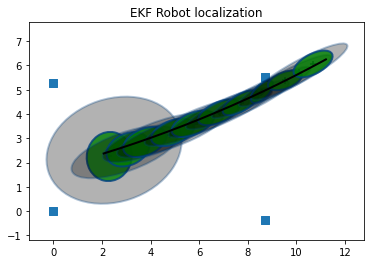

Final P: [0.01791953 0.00943916 0.00094087]


In [9]:
landmarks = np.array([[0, 0], [8.692, -0.347], [8.692, 5.519], [0, 5.295]])

ekf = run_localization(
    landmarks, std_vel=0.5, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
print('Final P:', ekf.P.diagonal())

In [10]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

In [11]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
#     u[0] = 0 denotes moving in a straight line
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

In [12]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

In [13]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

In [14]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

In [15]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [24]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [50]:
zs

[array([2.02, 2.36]),
 array([2.02, 2.36]),
 array([2.02, 2.36]),
 array([2.02, 2.36]),
 array([2.02, 2.36]),
 array([2.02, 2.36]),
 array([2.02, 2.36]),
 array([2.02, 2.36]),
 array([2.02, 2.36]),
 array([2.02, 2.36]),
 array([2.01, 2.37]),
 array([2.01, 2.37]),
 array([2.01, 2.37]),
 array([2.01, 2.37]),
 array([2.01, 2.37]),
 array([2.01, 2.37]),
 array([2.01, 2.37]),
 array([2.01, 2.37]),
 array([2.01, 2.37]),
 array([2.01, 2.37]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.02, 2.37]),
 array([2.02, 2.37]),
 array([2.02, 2.37]),
 array([2.02, 2.37]),
 array([2.02, 2.37]),
 array([2.02, 2.37]),
 array([2.02, 2.37]),
 array([2.02, 2.37]),
 array([2.02, 2.37]),
 array([2.02, 2.37]),
 array([2.02, 2.37]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.01, 2.38]),
 array([2.

robot_pos = [2.52625 2.34375]
robot_pos = [3.0325 2.3275]
robot_pos = [3.53875 2.31125]
robot_pos = [4.045 2.295]
robot_pos = [4.55125 2.27875]
robot_pos = [5.0575 2.2625]
robot_pos = [5.56375 2.24625]
robot_pos = [6.07 2.23]
final position error, variance:
	 [-1.91267735 -5.73425908] [0.00103704 0.00301769]


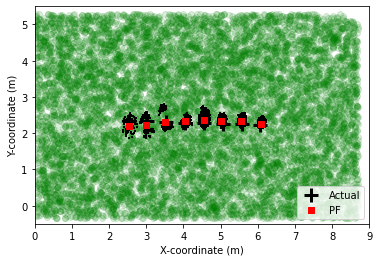

In [75]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 9), ylim=(-0.5, 5.5),
            initial_x=None):
    landmarks = np.array([[0, 0], [8.692, -0.347], [8.692, 5.519], [0, 5.295]])
    NL = len(landmarks)
    
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        print(f"initial_x = {initial_x}")
        particles = create_gaussian_particles(
            mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
#         xrange, yrange
        particles = create_uniform_particles((0, 8.692), (-0.347, 5.295), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([uwb_x[ini_index], uwb_y[ini_index]])
    for x in range(iters):
#         robot move forward 4.06m in iters
        robot_pos += (forward/iters, lateral/iters)
        print(f"robot_pos = {robot_pos}")

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + 
              (randn(NL) * sensor_std_err))

        # move forward to (x + dx, y + dy)
        predict(particles, u=(0.00, sqrt(forward/iters)**2 + (lateral/iters)**2), std=(process_std, process_std_lateral))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
#     plt.plot(xs[:, 0], xs[:, 1])         
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.xlabel("X-coordinate (m)")
    plt.ylabel("Y-coordinate (m)")
#     plt.show()
#     plt.savefig('pf10k.pdf', dpi=300)

run_pf1(N=10000, iters=8, plot_particles=True)

In [ ]:
import numpy as np
import scipy as scipy
from numpy.random import uniform
import scipy.stats


np.set_printoptions(threshold=3)
np.set_printoptions(suppress=True)
import cv2


def drawLines(img, points, r, g, b):
    cv2.polylines(img, [np.int32(points)], isClosed=False, color=(r, g, b))

def drawCross(img, center, r, g, b):
    d = 5
    t = 2
    LINE_AA = cv2.LINE_AA if cv2.__version__[0] == '3' else cv2.LINE_AA
    color = (r, g, b)
    ctrx = center[0,0]
    ctry = center[0,1]
    cv2.line(img, (ctrx - d, ctry - d), (ctrx + d, ctry + d), color, t, LINE_AA)
    cv2.line(img, (ctrx + d, ctry - d), (ctrx - d, ctry + d), color, t, LINE_AA)
    

def mouseCallback(event, x, y, flags,null):
    global center
    global trajectory
    global previous_x
    global previous_y
    global zs
    
    center=np.array([[x,y]])
    trajectory=np.vstack((trajectory,np.array([x,y])))
    #noise=sensorSigma * np.random.randn(1,2) + sensorMu
    
    if previous_x >0:
        heading=np.arctan2(np.array([y-previous_y]), np.array([previous_x-x ]))

        if heading>0:
            heading=-(heading-np.pi)
        else:
            heading=-(np.pi+heading)
            
        distance=np.linalg.norm(np.array([[previous_x,previous_y]])-np.array([[x,y]]) ,axis=1)
        
        std=np.array([2,4])
        u=np.array([heading,distance])
        predict(particles, u, std, dt=1.)
        zs = (np.linalg.norm(landmarks - center, axis=1) + (np.random.randn(NL) * sensor_std_err))
        update(particles, weights, z=zs, R=50, landmarks=landmarks)
        
        indexes = systematic_resample(weights)
        resample_from_index(particles, weights, indexes)

    previous_x=x
    previous_y=y
    
WIDTH=800
HEIGHT=600
WINDOW_NAME="Particle Filter"

#sensorMu=0
#sensorSigma=3

sensor_std_err=5


def create_uniform_particles(x_range, y_range, N):
    particles = np.empty((N, 2))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    return particles



def predict(particles, u, std, dt=1.):
    N = len(particles)
    dist = (u[1] * dt) + (np.random.randn(N) * std[1])
    particles[:, 0] += np.cos(u[0]) * dist
    particles[:, 1] += np.sin(u[0]) * dist
    

def update(particles, weights, z, R, landmarks):
    weights.fill(1.)
    for i, landmark in enumerate(landmarks):
       
        distance=np.power((particles[:,0] - landmark[0])**2 +(particles[:,1] - landmark[1])**2,0.5)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

 
    weights += 1.e-300 # avoid round-off to zero
    weights /= sum(weights)
    
def neff(weights):
    return 1. / np.sum(np.square(weights))

def systematic_resample(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.random()) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N and j<N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes
    
def estimate(particles, weights):
    pos = particles[:, 0:1]
    mean = np.average(pos, weights=weights, axis=0)
    var = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights /= np.sum(weights)

    
x_range=np.array([0,800])
y_range=np.array([0,600])

#Number of partciles
N=400

landmarks = np.array([ [144,73], [410,13], [336,175], [718,159], [178,484], [665,464]])
NL = len(landmarks)
particles=create_uniform_particles(x_range, y_range, N)


weights = np.array([1.0]*N)


# Create a black image, a window and bind the function to window
img = np.zeros((HEIGHT,WIDTH,3), np.uint8)
cv2.namedWindow(WINDOW_NAME)
cv2.setMouseCallback(WINDOW_NAME,mouseCallback)

center=np.array([[-10,-10]])

trajectory=np.zeros(shape=(0,2))
robot_pos=np.zeros(shape=(0,2))
previous_x=-1
previous_y=-1
DELAY_MSEC=50

while(1):

    cv2.imshow(WINDOW_NAME,img)
    img = np.zeros((HEIGHT,WIDTH,3), np.uint8)
    drawLines(img, trajectory,   0,   255, 0)
    drawCross(img, center, r=255, g=0, b=0)
    
    #landmarks
    for landmark in landmarks:
        cv2.circle(img,tuple(landmark),10,(255,0,0),-1)
    
    #draw_particles:
    for particle in particles:
        cv2.circle(img,tuple((int(particle[0]),int(particle[1]))),1,(255,255,255),-1)
    
    # Esc key to stop
    if cv2.waitKey(DELAY_MSEC) & 0xFF == 27:
        break
    
    cv2.circle(img,(10,10),10,(255,0,0),-1)
    cv2.circle(img,(10,30),3,(255,255,255),-1)
    cv2.putText(img,"Landmarks",(30,20),1,1.0,(255,0,0))
    cv2.putText(img,"Particles",(30,40),1,1.0,(255,255,255))
    cv2.putText(img,"Robot Trajectory(Ground truth)",(30,60),1,1.0,(0,255,0))

    drawLines(img, np.array([[10,55],[25,55]]), 0, 255, 0)
    
cv2.destroyAllWindows()